In [1]:
import pandas as pd
import numpy as np
from bioreactor.plotting import *
from bioreactor.use_colors import *
from bioreactor.annotation import *
from bioreactor.utils import read_dataset, median_scale
from bioreactor.ssgsea import *
from bioreactor.gsea import *
#from bioreactor.expression import  *
from bioreactor.pathway_scoring import *
from bioreactor.survival import * 
from bioreactor.graphs import *

from bioreactor.plotting import *
from bioreactor.use_colors import *
from bioreactor.utils import *
from bioreactor.gsea import *
from bioreactor.mutations import *
from bioreactor.ssgsea import *
from bioreactor.clustering import *
from bioreactor.oncoplot2 import *
from bioreactor.cna import *

from mldeconv.cells_plotting import *
from mldeconv.data_loading import *
from sklearn.model_selection import train_test_split

from typing import Tuple, List, Optional
import warnings
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
from scipy.stats import spearmanr
import scipy

from collections import defaultdict
from scipy.spatial.distance import pdist, squareform
import itertools as it

import warnings
warnings.filterwarnings('ignore')

# Particular example: macrophages

## Read data

In [3]:
from mldeconv.cells_plotting import *
from mldeconv.data_loading import *

In [4]:
from tqdm.notebook import tqdm

In [5]:
def get_gspread(table, sheet, index_col=0, path_to_json=None): 
    """
    Access Google Sheets via python
    
    :param path_to_json: absolute path to JSON containing creditials for Google API
    :param table: Annotation calculated, for instance
    :param sheet: Blood, for instance
    :param index_col: column number
    :return: pandas DataFrame
    """
    from oauth2client.service_account import ServiceAccountCredentials
    import gspread
    
    if path_to_json == None:
        path_to_json = '/uftp/Blood/google_secret.json'

    credentials = ServiceAccountCredentials.from_json_keyfile_name(
        path_to_json)  # Your json file here
    gc = gspread.authorize(credentials)

    # open table
    wks = gc.open(table)
    # select sheet
    sheet = wks.worksheet(sheet)
    data = pd.DataFrame(sheet.get_all_records())
    data = data.set_index(data.columns[index_col])
    return data

In [6]:
cells_clean = read_dataset('/uftp2/Databases/sorted_cell_databases/current_version/cells_clean_annotation.tsv')

In [7]:
cells_clean = cells_clean[(~cells_clean.index.str.contains('RNA'))&(~cells_clean.index.str.contains('WES'))&(~cells_clean.index.str.contains('210514_NovaA'))]

In [8]:
cells_clean = cells_clean[['Cell_type', 'Dataset', 'Sample', 'Cell_origin']]
public_cells_annot = cells_clean.copy()
public_cells_annot = public_cells_annot.reset_index(drop=True)

In [9]:
# split celltypes in case there are multiple celltypes per sample

celltypes_split = pd.DataFrame()

for i, j in public_cells_annot.dropna(subset=['Cell_type']).iterrows():
    if ';' in j['Cell_type']:
        ct = j['Cell_type'].split(';')
        new_row = j.copy()
        for c in ct:
            new_row['Cell_type'] = c
            celltypes_split = celltypes_split.append(new_row, ignore_index=True)
        public_cells_annot.drop(i, inplace=True)
        
public_cells_annot = public_cells_annot.append(celltypes_split)

In [10]:
public_cells_annot.index = public_cells_annot.Sample

In [11]:
# TAM
public_cells_annot['Cell_type'] = [public_cells_annot[public_cells_annot.index == x]['Cell_type'].replace('Macrophages', 'TAM').get(x) if x in ['SRX4495404', 'ERX1270123', 'ERX1270124', 'ERX1270125', 'ERX1270126', 'ERX1270127', 'ERX1270128', 'ERX1270130'] else public_cells_annot[public_cells_annot.index == x]['Cell_type'].get(x) for x in public_cells_annot.index]

In [12]:
# Mast cells
cells_annot = get_gspread('Cells', 'Cells')
cells_annot = cells_annot.loc[cells_annot.Cell_type.str.contains('Mast_cells')]
cells_annot = prepare_sample_annot(cells_annot)
cells_annot = cells_annot[['Cell_type', 'Dataset', 'Cell_origin']]
cells_to_check_annot = get_gspread('Annotation calculated', 'Cells_to_check')
cells_to_check_annot = cells_to_check_annot.loc[cells_to_check_annot.Cell_type.str.contains('Mast_cells')]
cells_to_check_annot = prepare_sample_annot(cells_to_check_annot)
cells_to_check_annot = cells_to_check_annot[['Cell_type', 'Dataset', 'Cell_origin']]
public_cells_annot = pd.concat([public_cells_annot, cells_annot, cells_to_check_annot])
public_cells_annot = public_cells_annot.loc[~public_cells_annot.index.isin(['SRX5026003', 'SRX5026001', 'SRX5026000', 'SRX5026002', 'SRX5025998', 'SRX5025999', 'SRX9977242', 'SRX9977243'])] #bad samples

In [13]:
# Tonsillar Tfh
public_cells_annot['Cell_type'] = [public_cells_annot[public_cells_annot.index == x]['Cell_type'].replace('Follicular_T_helper', 'Follicular_T_helper_tonsil').get(x) if x in ['SRX3803662', 'SRX3803661', 'SRX3803659'] else public_cells_annot[public_cells_annot.index == x]['Cell_type'].get(x) for x in public_cells_annot.index]
cells_annot = get_gspread('Cells', 'Cells')
cells_annot = cells_annot.loc[cells_annot.Sample.isin(['SRX5799646', 'SRX5799650', 'SRX5799654', 'SRX5824180', 'SRX5824194', 'SRX5824202', 'SRX5824210', 'SRX5824217', 'SRX609020'])]
cells_annot.index = cells_annot['Sample']
cells_annot['Cell_type'] = 'Follicular_T_helper_tonsil'
cells_annot = cells_annot[['Cell_type', 'Dataset', 'Cell_origin']]
cells_to_check_annot = get_gspread('Annotation calculated', 'Cells_to_check')
cells_to_check_annot = cells_to_check_annot.loc[cells_to_check_annot.Sample.isin(['SRX10253425', 'SRX10253439', 'SRX10253463', 'SRX10253470', 'SRX10253444', 'SRX10253451'])]
cells_to_check_annot.index = cells_to_check_annot['Sample']
cells_to_check_annot['Cell_type'] = 'Follicular_T_helper_tonsil'
cells_to_check_annot = cells_to_check_annot[['Cell_type', 'Dataset', 'Cell_origin']]
public_cells_annot = pd.concat([public_cells_annot, cells_annot, cells_to_check_annot])
public_cells_annot = public_cells_annot.loc[~public_cells_annot.index.isin(['SRX10253432', 'SRX609018', 'SRX609019', 'SRX5824207', 'SRX5824208', 'SRX5824209', 'SRX5824201', 'SRX5824214', 'SRX5824215', 'SRX5824216', 'SRX5824199', 'SRX5824200', 'SRX5799647', 'SRX5799655', 'SRX5799651', 'SRX5824177', 'SRX5824178', 'SRX5824179', 'SRX5824191', 'SRX5824192', 'SRX5824193', 'SRX5824184', 'SRX5824185', 'SRX5824186', 'SRX5824187', ])] #bad samples

In [15]:
'''# microglia from cells_to_check
cells_to_check_annot = get_gspread('Annotation calculated', 'Cells_to_check')
cells_to_check_annot = cells_to_check_annot.loc[cells_to_check_annot.Cell_type_details.str.contains('Microglia')]
cells_to_check_annot['Cell_type'] = cells_to_check_annot['Cell_type_details']
cells_to_check_annot = cells_to_check_annot.loc[~cells_to_check_annot.Sample.isin(['SRX1631015', 'SRX1631296', 'SRX1631316'])] #samples contaminated with neutrophils
cells_to_check_annot = prepare_sample_annot(cells_to_check_annot)
cells_to_check_annot = cells_to_check_annot[['Cell_type', 'Dataset']]
public_cells_annot = pd.concat([public_cells_annot, cells_to_check_annot])'''

"# microglia from cells_to_check\ncells_to_check_annot = get_gspread('Annotation calculated', 'Cells_to_check')\ncells_to_check_annot = cells_to_check_annot.loc[cells_to_check_annot.Cell_type_details.str.contains('Microglia')]\ncells_to_check_annot['Cell_type'] = cells_to_check_annot['Cell_type_details']\ncells_to_check_annot = cells_to_check_annot.loc[~cells_to_check_annot.Sample.isin(['SRX1631015', 'SRX1631296', 'SRX1631316'])] #samples contaminated with neutrophils\ncells_to_check_annot = prepare_sample_annot(cells_to_check_annot)\ncells_to_check_annot = cells_to_check_annot[['Cell_type', 'Dataset']]\npublic_cells_annot = pd.concat([public_cells_annot, cells_to_check_annot])"

In [16]:
# CAFs
public_cells_annot['Cell_type'] = [public_cells_annot[public_cells_annot.index == x]['Cell_type'].replace('Fibroblasts', 'CAF').get(x) if x in ['SRX1707754', 'SRX1707755', 'SRX1707757', 'SRX1707758', 'SRX1707759', 'SRX1707760', 'SRX1841548', 'SRX1841550', 'SRX1884188', 'SRX1884189', 'SRX1884190', 'SRX1884191', 'SRX1884192', 'SRX1884193', 'SRX1884194', 'SRX1884195', 'SRX1884196', 'SRX1884197', 'SRX2023079', 'SRX2023080', 'SRX2023081', 'SRX2023082', 'ERX2297292', 'ERX2297293', 'ERX2297295', 'ERX2297296'] else public_cells_annot[public_cells_annot.index == x]['Cell_type'].get(x) for x in public_cells_annot.index]

In [18]:
# Pericytes
'''cells_annot = get_gspread('Cells', 'Cells')
cells_annot = cells_annot.loc[cells_annot.Cell_type.str.contains('Pericytes')]
cells_annot = prepare_sample_annot(cells_annot)
cells_annot = cells_annot[['Cell_type', 'Dataset', 'Cell_origin']]
cells_to_check_annot = get_gspread('Annotation calculated', 'Cells_to_check')
cells_to_check_annot = cells_to_check_annot.loc[cells_to_check_annot.Cell_type.str.contains('Pericytes')]
cells_to_check_annot = prepare_sample_annot(cells_to_check_annot)
cells_to_check_annot = cells_to_check_annot[['Cell_type', 'Dataset', 'Cell_origin']]
public_cells_annot = pd.concat([public_cells_annot, cells_annot, cells_to_check_annot])'''

"cells_annot = get_gspread('Cells', 'Cells')\ncells_annot = cells_annot.loc[cells_annot.Cell_type.str.contains('Pericytes')]\ncells_annot = prepare_sample_annot(cells_annot)\ncells_annot = cells_annot[['Cell_type', 'Dataset', 'Cell_origin']]\ncells_to_check_annot = get_gspread('Annotation calculated', 'Cells_to_check')\ncells_to_check_annot = cells_to_check_annot.loc[cells_to_check_annot.Cell_type.str.contains('Pericytes')]\ncells_to_check_annot = prepare_sample_annot(cells_to_check_annot)\ncells_to_check_annot = cells_to_check_annot[['Cell_type', 'Dataset', 'Cell_origin']]\npublic_cells_annot = pd.concat([public_cells_annot, cells_annot, cells_to_check_annot])"

In [19]:
# Epithelium
cells_annot = get_gspread('Cells', 'Cells')
cells_annot = cells_annot.loc[cells_annot.Cell_type.str.contains('Epithelium')]
cells_annot = cells_annot.loc[~cells_annot['Readcounts'].isin([''])]
cells_annot = cells_annot.loc[~cells_annot['QC_score'].isin([''])]
cells_annot = prepare_sample_annot(cells_annot)
cells_annot = cells_annot[['Cell_type', 'Dataset', 'Cell_origin']]
cells_annot = cells_annot.loc[~cells_annot.index.isin(['SRX3862287', 'SRX1023930', 'SRX1023931', 'SRX1023932', 'SRX3862298', 'SRX3862286', 'SRX4794853', 'SRX4794854', 'SRX4794855', 'SRX4794856', 'SRX4794857', 'SRX3862299', 'SRX3862345', 'SRX4123705', 'SRX3862310', 'SRX3862344', 'SRX3862323', 'SRX3832322', 'SRX3862311'])] #bad samples
public_cells_annot = pd.concat([public_cells_annot, cells_annot])

In [20]:
public_cells_expr = read_expressions(public_cells_annot)
public_cells_expr = np.log2(public_cells_expr+1)

no GSE183854 expression
no GSE199286 expression
no GSE162712 expression
no GSE199490 expression
no GSE214624 expression


## Figures

In [22]:
#define celltypes of interest
categories = ['Macrophages', 'Macrophages_M1', 'Macrophages_M2', 'TAM', 'Microglia', 'Monocytes', 'CDC1', 'CDC', 'PDC', 
              'Eosinophils', 'Basophils', 'Mast_cells', 'Neutrophils',
              'CD4_T_cells', 'Tregs', 
              'CD8_T_cells', 'MAIT_cells', 'gd_T_cells',
              'NK_cells', 'B_cells', 'Plasma_B_cells',
              'Fibroblasts', 'Endothelium', 'Epithelium',
             ]


annot = public_cells_annot.loc[public_cells_annot['Cell_type'].isin(categories)]
annot = annot.loc[~annot.index.isin(['SRX6369364', 'SRX7052817', 'SRX3361935', 'SRX3208751', 'SRX3208713'])] #dirty samples
annot = annot[~annot.index.duplicated()]
#for sorting in the required order, could be skipped if the sorting is not needed
annot.Cell_type = pd.Categorical(annot['Cell_type'],
                                    categories=categories,
                                    ordered=True)
annot = annot.sort_values('Cell_type')

In [23]:
signature_of_interest = '''MARCO, CXCL5, SCG5, SULT1C2, MSR1, CTSK, PTGDS, COLEC12, GPC4, PCOLCE2, CHIT1, ANOS1, CLEC5A, ME1, DNASE2B, CCL7, FN1, CD163, GM2A, SCARB2, BCAT1, RAI14, COL8A2, APOE, CHI3L1, ATG7, CD84, FDX1, MS4A4A, SGMS1, EMP1, CYBB, CD68'''.split(', ')

#add here a custon signature name
signature_name = 'Macrophages'
geneset_of_interest = {signature_name:GeneSet(signature_name, '', signature_of_interest)}

In [32]:
public_cells_expr = public_cells_expr.T[~public_cells_expr.columns.duplicated()].T
public_cells_ssgsea_unscaled = ssgsea_formula(public_cells_expr, gmt_genes_alt_names(geneset_of_interest, public_cells_expr.index, verbose=False)).T

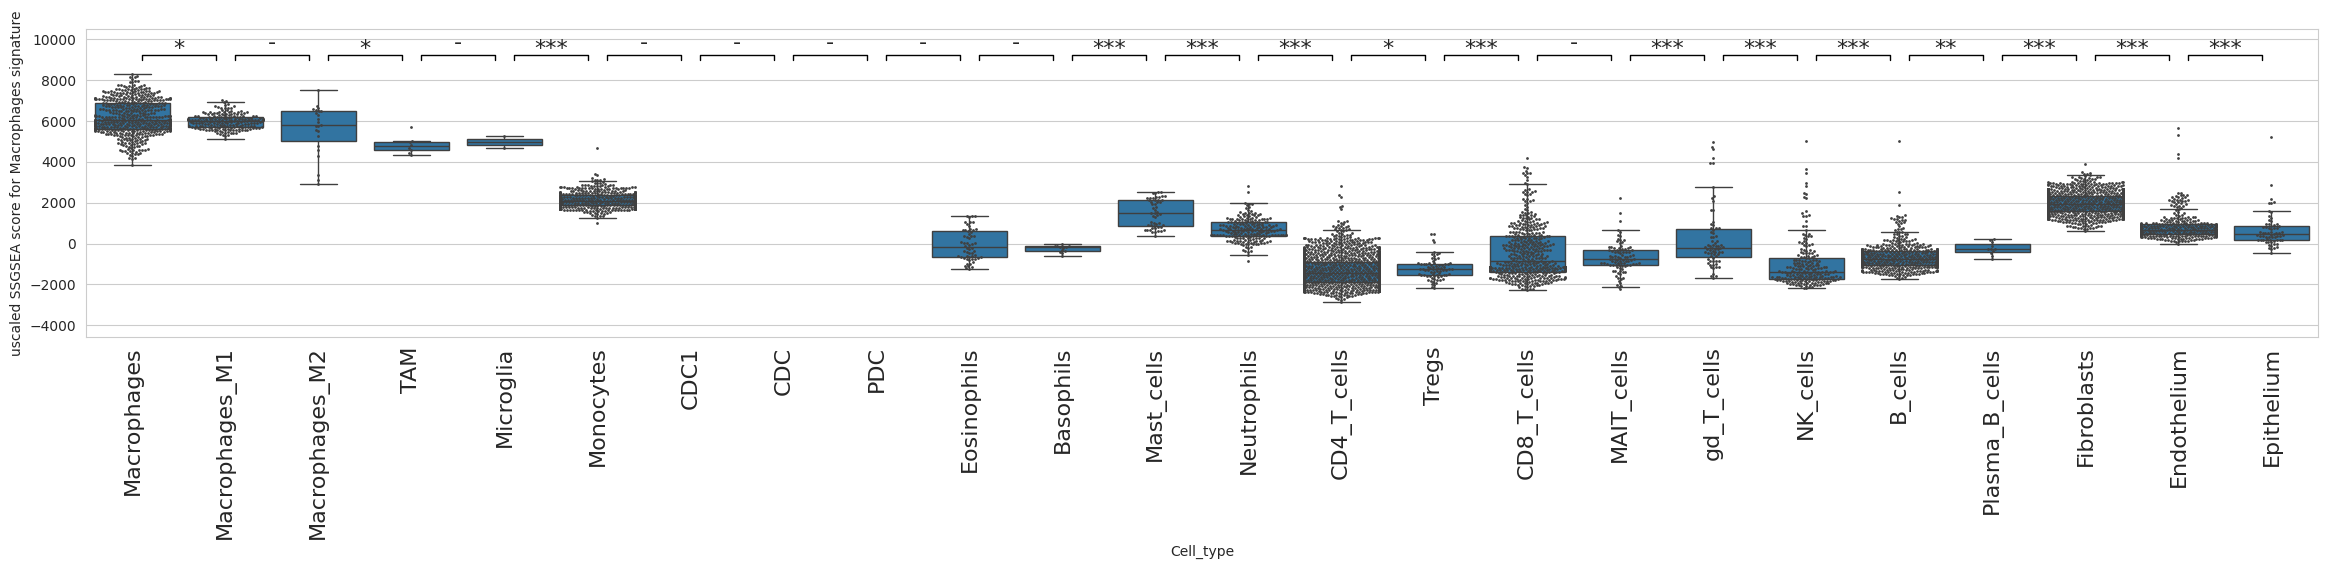

In [33]:
# boxplot depicting signature SSGSEA score in celltypes of interest

categories = ['Macrophages', 'Macrophages_M1', 'Macrophages_M2', 'TAM', 'Microglia', 'Monocytes', 'CDC1', 'CDC', 'PDC', 
              'Eosinophils', 'Basophils', 'Mast_cells', 'Neutrophils',
              'CD4_T_cells', 'Tregs', 
              'CD8_T_cells', 'MAIT_cells', 'gd_T_cells',
              'NK_cells', 'B_cells', 'Plasma_B_cells',
              'Fibroblasts', 'Endothelium', 'Epithelium',            
]

boxplot_with_pvalue(public_cells_ssgsea_unscaled[signature_name], annot[annot['Cell_type'].isin(categories)]['Cell_type'], 
                   order = categories, s=2, p_fontsize=16)

plt.xticks(rotation=90, fontsize=16)
plt.ylabel(f'uscaled SSGSEA score for {signature_name} signature')
plt.show()

In [34]:
group_of_interest = 'Macrophages_M1'
similar_group = 'Macrophages'
alike_group = 'Monocytes'
different_group = 'Fibroblasts'

In [35]:
gene_order = ['FDX1', 'SULT1C2', 'SCG5', 'SGMS1', 'ME1', 'EMP1', 'PCOLCE2', 'SCARB2',
       'DNASE2B', 'GPC4', 'APOE', 'CXCL5', 'PTGDS', 'CHI3L1', 'RAI14', 'ANOS1',
       'COL8A2', 'CHIT1', 'CTSK', 'CCL7', 'COLEC12', 'GM2A', 'FN1', 'ATG7',
       'BCAT1', 'MARCO', 'CLEC5A', 'CD68', 'CD163', 'MS4A4A', 'MSR1', 'CD84',
       'CYBB']

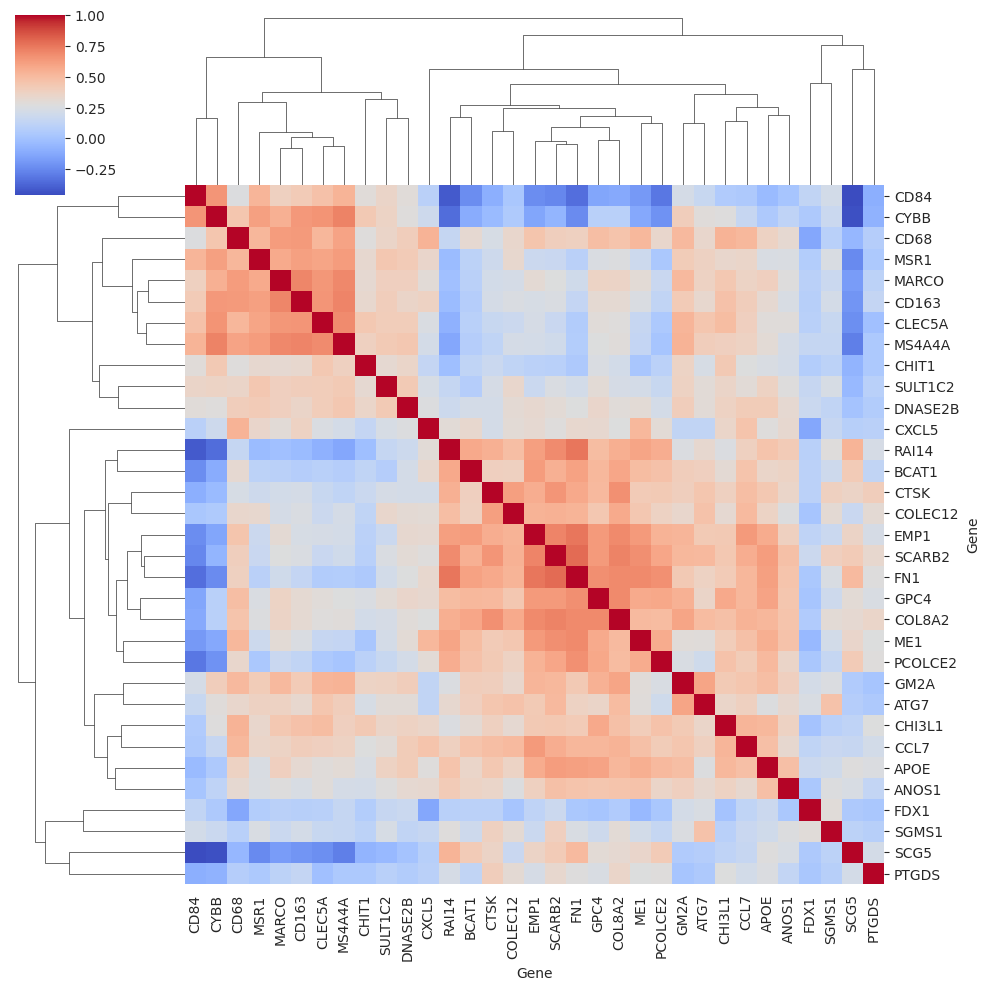

In [36]:
corr = public_cells_expr.reindex(gene_order).T.corr(method='spearman')
g = sns.clustermap(corr, cmap = default_cmap)

In [37]:
def cohen_d(x,y):
        return (np.mean(x) - np.mean(y)) / np.sqrt((np.std(x, ddof=1) ** 2 + np.std(y, ddof=1) ** 2) / 2.0)


In [39]:
from tqdm import tqdm

cd_similar = []
cd_alike = []
cd_different = []
genes = []

modified_signature = signature_of_interest.copy()
for gene_to_remove in tqdm(gene_order):
    #print(gene_to_remove)
    modified_signature.remove(gene_to_remove)
    genes.append(gene_to_remove)
    geneset = {signature_name:GeneSet(signature_name, '', modified_signature)}
    s = ssgsea_formula(public_cells_expr, gmt_genes_alt_names(geneset, public_cells_expr.index, verbose=False)).T
    
    goi_scores = s.reindex(annot[annot['Cell_type'] == group_of_interest].index)
    sim_scores = s.reindex(annot[annot['Cell_type'] == similar_group].index)
    alike_scores = s.reindex(annot[annot['Cell_type'] == alike_group].index)
    diff_scores = s.reindex(annot[annot['Cell_type'] == different_group].index)
    
    sim = cohen_d(goi_scores, sim_scores).values.tolist()[0]
    alike = cohen_d(goi_scores, alike_scores).values.tolist()[0]
    diff = cohen_d(goi_scores, diff_scores).values.tolist()[0]
    
    cd_similar.append(sim)
    cd_alike.append(alike)
    cd_different.append(diff)


100%|██████████| 33/33 [10:28<00:00, 19.06s/it]


In [40]:
group_of_interest = 'Macrophages'
similar_group = 'Macrophages_M1'
alike_group = 'Monocytes'
different_group = 'Fibroblasts'

In [41]:
plt.rcParams['svg.fonttype'] = 'none'

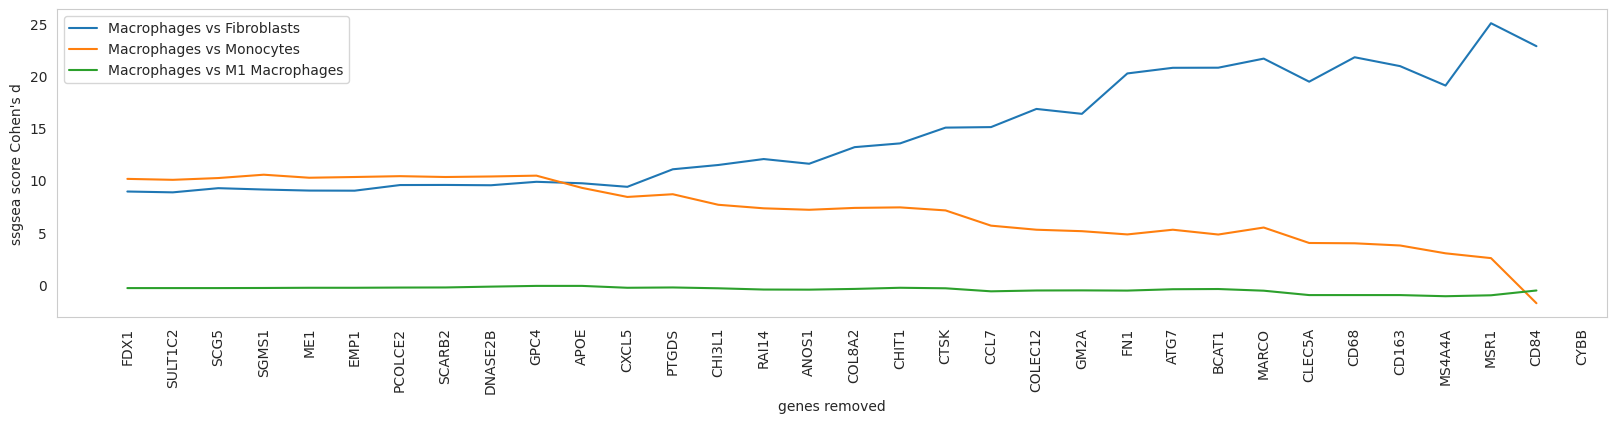

In [42]:
plt.figure(figsize = (20, 4))
#plt.subplots()
plt.plot(genes, np.round(np.array(cd_different), 2), label = 'Macrophages vs Fibroblasts')
plt.plot(genes, np.round(np.array(cd_alike), 2), label = 'Macrophages vs Monocytes')
plt.plot(genes, np.round(np.array(cd_similar), 2), label = 'Macrophages vs M1 Macrophages')
plt.xticks(rotation=90)
plt.ylabel("ssgsea score Cohen's d")
plt.xlabel('genes removed')
plt.legend()
plt.grid(b=None)
#plt.savefig(f"/home/eocheredko/Chess_projects/Signature_validation_paper/Figures/Macrophages_corr.svg", format="svg")
plt.show()